In [32]:
import io
import os
import numpy as np

import pandas as pd
import nltk.translate.bleu_score as bleu
from datasets import load_dataset

try:
    import tensorflow  # required in Colab to avoid protobuf compatibility issues
except ImportError:
    pass

import torch
import pandas as pd
import urllib
import tarfile
import whisper
import torchaudio

from scipy.io import wavfile
from tqdm.notebook import tqdm


pd.options.display.max_rows = 100
pd.options.display.max_colwidth = 1000
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

import string
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.ticker as ticker

from IPython.display import display, HTML
from whisper.tokenizer import get_tokenizer
from dtw import dtw
from scipy.ndimage import median_filter

%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [70]:
# dataset = load_dataset("google/fleurs", 'en_us')
# df = pd.DataFrame(dataset['train'])
df = pd.read_csv('dataframe.csv')

In [27]:
# set up the BLEU score calculation
weights = (0.25, 0.25, 0.25, 0.25)  # uniform weights for 1-gram to 4-gram
smooth_func = bleu.SmoothingFunction().method1  # use smoothing method 1


In [28]:
def calculate_bleu(row):
    bleu_score = bleu.sentence_bleu([row['raw_transcription'].split()], row['transcription'].split(), weights, smoothing_function=smooth_func)
    return bleu_score

df['bleu_score'] = df.apply(calculate_bleu, axis=1)


In [33]:
lang = "en_us"
language = "English"

In [34]:
model = whisper.load_model("medium")
print(
    f"Model is {'multilingual' if model.is_multilingual else 'English-only'} "
    f"and has {sum(np.prod(p.shape) for p in model.parameters()):,} parameters."
)

Model is multilingual and has 762,321,920 parameters.


In [35]:
options = dict(language=language, beam_size=5, best_of=5)
transcribe_options = dict(task="transcribe", **options)
translate_options = dict(task="translate", **options)

In [ ]:
references = []
transcriptions = []
translations = []

for index, row in df.iterrows():
    # audio = torch.from_numpy(row['audio']['array']).to(torch.float32)
    audio, sample_rate = torchaudio.load(row['path'])
    audio = audio[0]
    
    text = row['transcription']

    transcription = model.transcribe(audio, **transcribe_options)["text"]
    translation = model.transcribe(audio, **translate_options)["text"]
    
    transcriptions.append(transcription)
    translations.append(translation)
    references.append(text)

In [38]:
AUDIO_SAMPLES_PER_TOKEN = whisper.audio.HOP_LENGTH * 2
AUDIO_TIME_PER_TOKEN = AUDIO_SAMPLES_PER_TOKEN / whisper.audio.SAMPLE_RATE

medfilt_width = 7
qk_scale = 1.0

tokenizer = get_tokenizer(model.is_multilingual, language=language)

In [39]:

font = "GoNotoCurrent.ttf"

font_release = "https://github.com/satbyy/go-noto-universal/releases/download/v5.2"
if not os.path.exists(font):
    download(f"{font_release}/{font}", font)

prop = fm.FontProperties(fname=font)
props = {'fontproperties': prop}

In [40]:
def split_tokens_on_unicode(tokens: torch.Tensor):
    words = []
    word_tokens = []
    current_tokens = []
    
    for token in tokens.tolist():
        current_tokens.append(token)
        decoded = tokenizer.decode_with_timestamps(current_tokens)
        if "\ufffd" not in decoded:
            words.append(decoded)
            word_tokens.append(current_tokens)
            current_tokens = []
    
    return words, word_tokens

def split_tokens_on_spaces(tokens: torch.Tensor):
    subwords, subword_tokens_list = split_tokens_on_unicode(tokens)
    words = []
    word_tokens = []
    
    for subword, subword_tokens in zip(subwords, subword_tokens_list):
        special = subword_tokens[0] >= tokenizer.eot
        with_space = subword.startswith(" ")
        punctuation = subword.strip() in string.punctuation
        if special or with_space or punctuation:
            words.append(subword)
            word_tokens.append(subword_tokens)
        else:
            words[-1] = words[-1] + subword
            word_tokens[-1].extend(subword_tokens)
    
    return words, word_tokens

In [41]:
split_tokens = split_tokens_on_spaces

In [42]:
# install hooks on the cross attention layers to retrieve the attention weights
QKs = [None] * model.dims.n_text_layer

for i, block in enumerate(model.decoder.blocks):
    block.cross_attn.register_forward_hook(
        lambda _, ins, outs, index=i: QKs.__setitem__(index, outs[-1])
    )

 A tornado is a spinning column of very low pressure air, which sucks the surrounding air inward and upward.


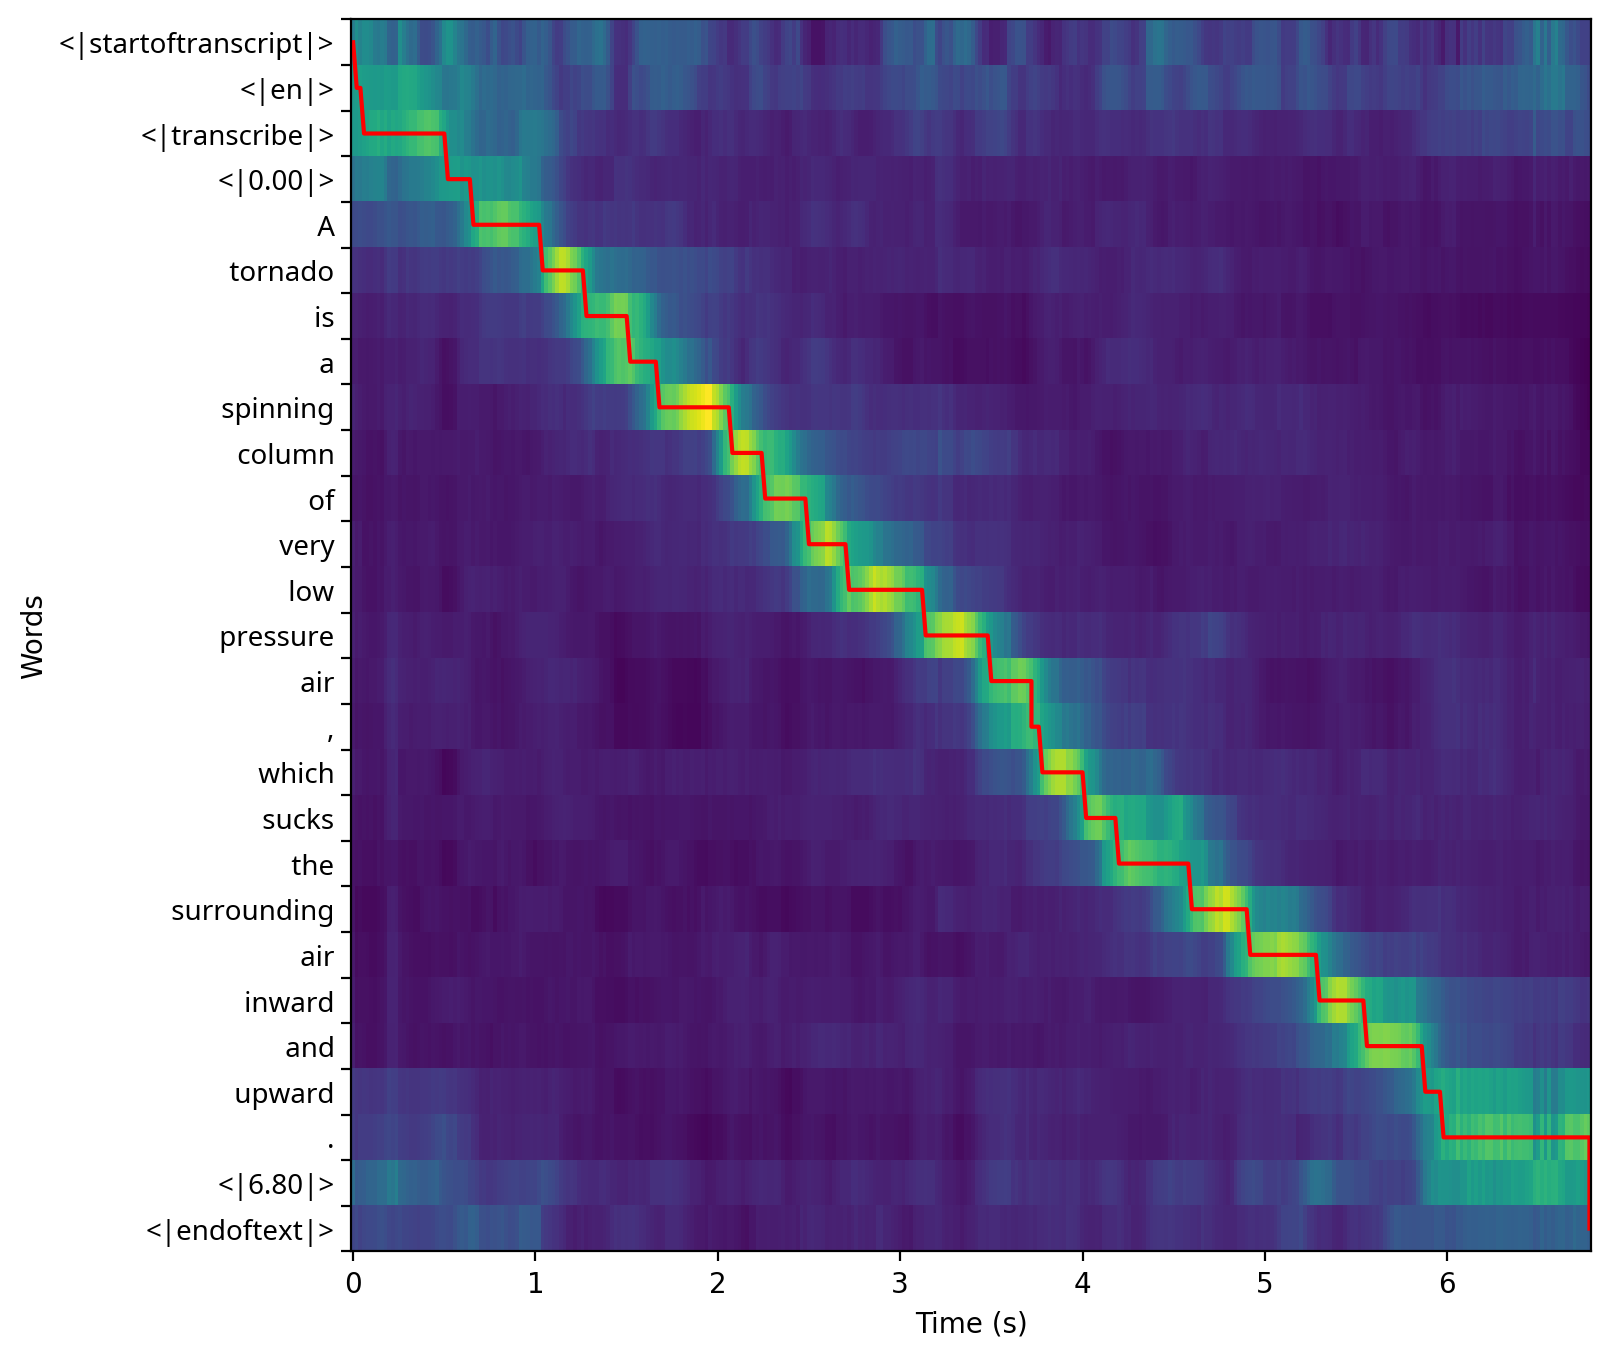

,word,begin,end
0,A,0.66,1.04
1,tornado,1.04,1.28
2,is,1.28,1.52
3,a,1.52,1.68
4,spinning,1.68,2.08
5,column,2.08,2.26
6,of,2.26,2.50
7,very,2.50,2.72
8,low,2.72,3.14
9,pressure,3.14,3.50


 Former U.S. Speaker of the House Newt Gingrich came in second with 32%.


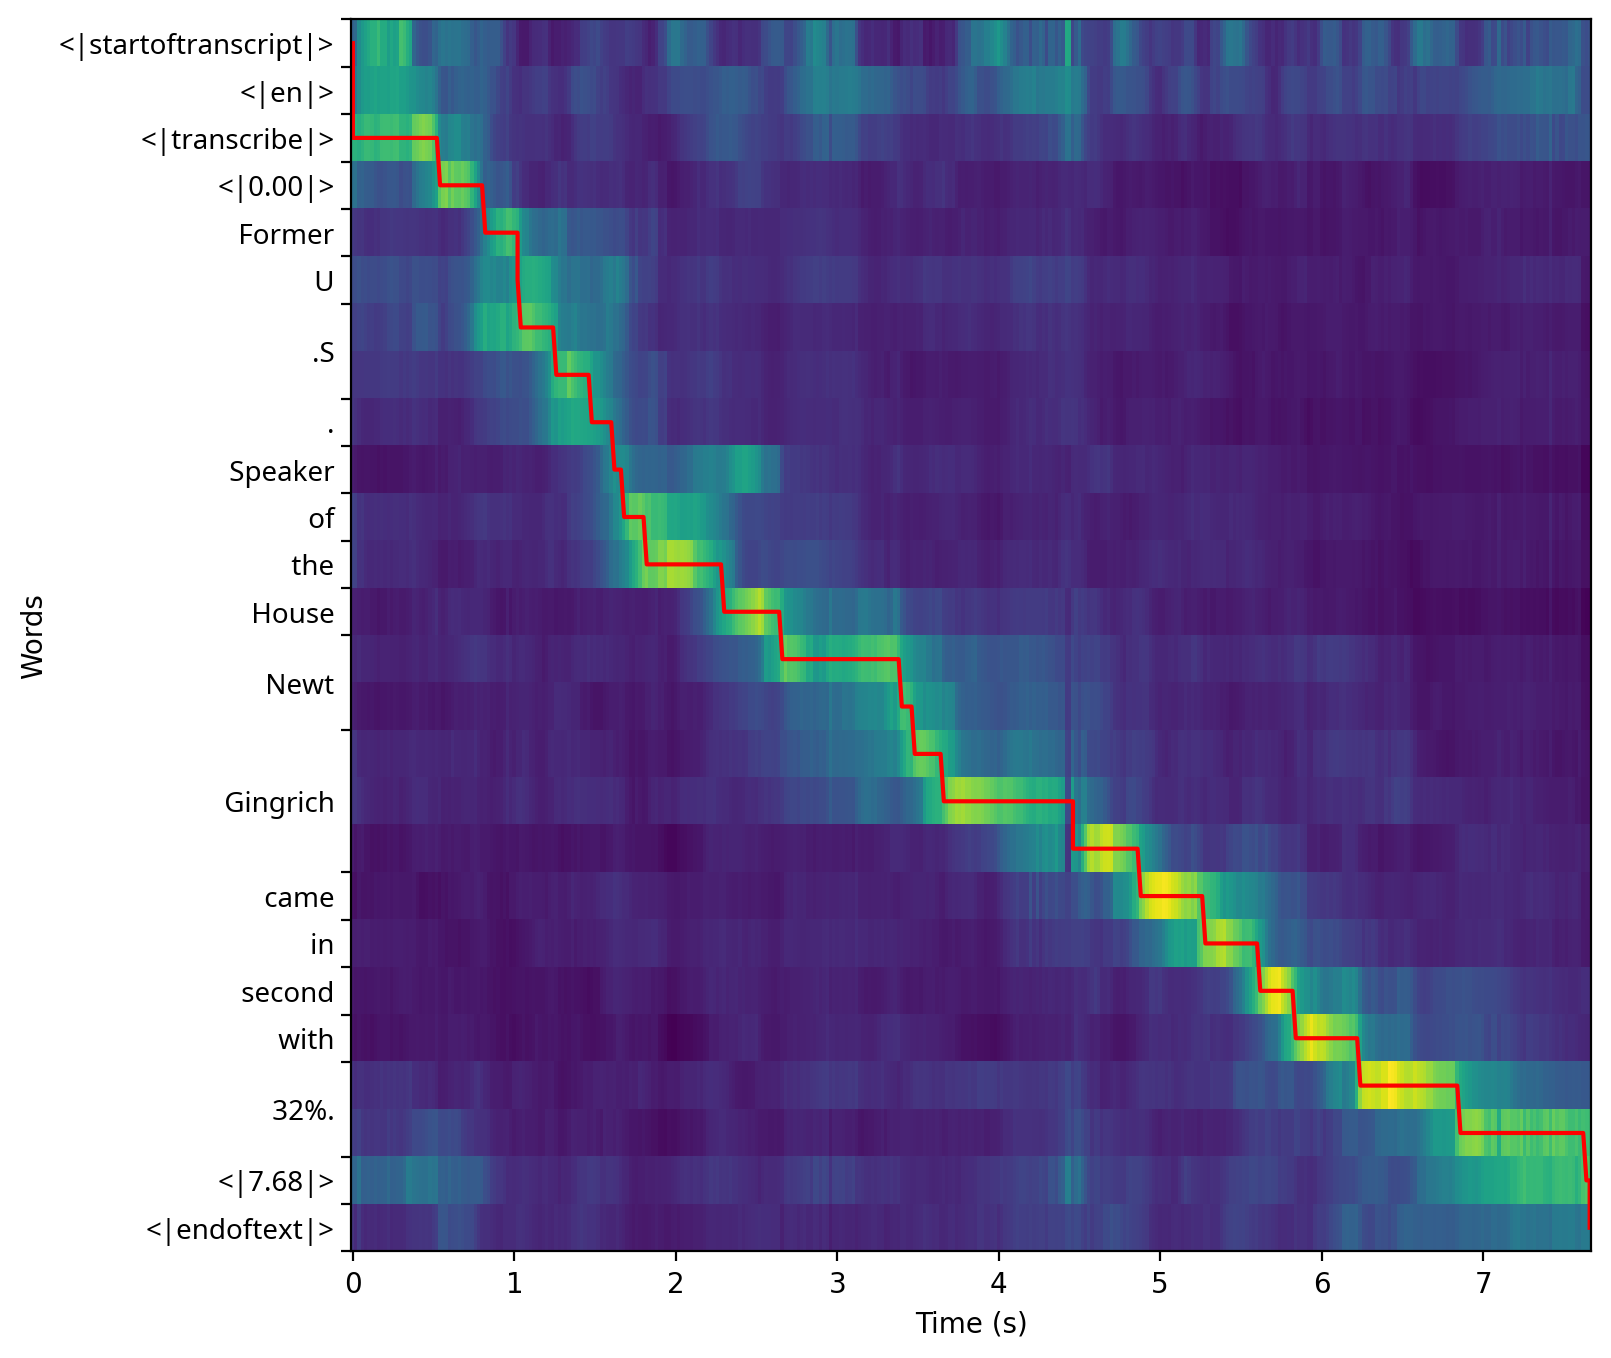

,word,begin,end
0,Former,0.82,1.02
1,U,1.02,1.04
2,.S,1.04,1.48
3,Speaker,1.62,1.68
4,of,1.68,1.82
5,the,1.82,2.30
6,House,2.30,2.66
7,Newt,2.66,3.48
8,Gingrich,3.48,4.88
9,came,4.88,5.28


 The island was first inhabited by the Tianos and Carribes. The Carribes were an Araucuacan speaking people who had arrived around 10,000 BCE.


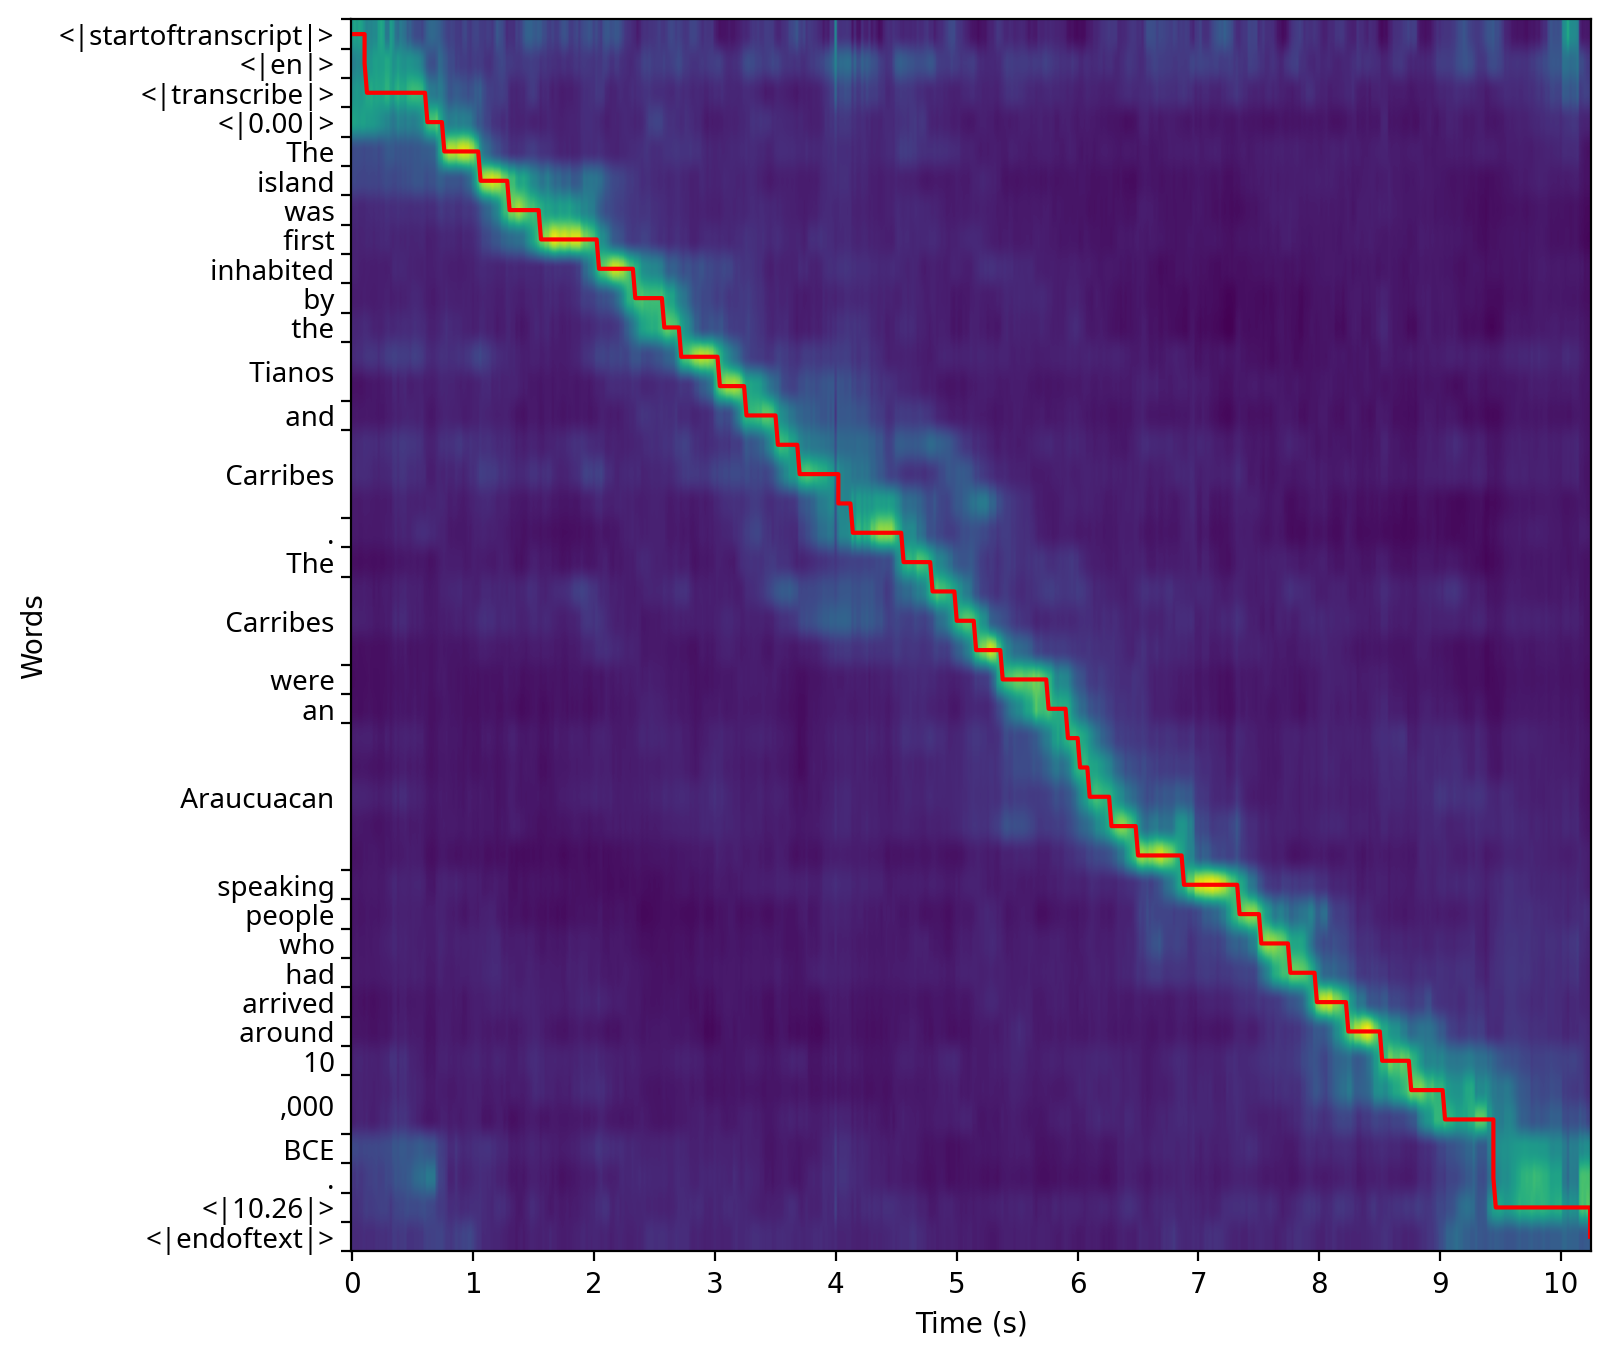

,word,begin,end
0,The,0.76,1.06
1,island,1.06,1.30
2,was,1.30,1.56
3,first,1.56,2.04
4,inhabited,2.04,2.34
5,by,2.34,2.58
6,the,2.58,2.72
7,Tianos,2.72,3.26
8,and,3.26,3.52
9,Carribes,3.52,4.14


In [ ]:
for (index, row), transcription in zip(df.iterrows(), transcriptions[:3]):
    # audio = torch.from_numpy(row['audio']['array']).to(torch.float32)
    audio, sample_rate = torchaudio.load(row['path'])
    audio = audio[0]
    label = row['transcription']
    
    print(transcription)
  
    duration = len(audio)
    # mel = whisper.log_mel_spectrogram(whisper.pad_or_trim(audio)).cuda()
    mel = whisper.log_mel_spectrogram(whisper.pad_or_trim(audio))

    # tokens = torch.tensor(
    #     [
    #         *tokenizer.sot_sequence,
    #         tokenizer.timestamp_begin,
    #     ] + tokenizer.encode(transcription) + [
    #         tokenizer.timestamp_begin + duration // AUDIO_SAMPLES_PER_TOKEN,
    #         tokenizer.eot,
    #     ]
    # ).cuda()
    tokens = torch.tensor(
        [
            *tokenizer.sot_sequence,
            tokenizer.timestamp_begin,
        ] + tokenizer.encode(transcription) + [
            tokenizer.timestamp_begin + duration // AUDIO_SAMPLES_PER_TOKEN,
            tokenizer.eot,
        ]
    )
    
    with torch.no_grad():
        logits = model(mel.unsqueeze(0), tokens.unsqueeze(0))

    weights = torch.cat(QKs)  # layers * heads * tokens * frames    
    weights = weights[:, :, :, : duration // AUDIO_SAMPLES_PER_TOKEN].cpu()
    weights = median_filter(weights, (1, 1, 1, medfilt_width))
    weights = torch.tensor(weights * qk_scale).softmax(dim=-1)
    
    w = weights / weights.norm(dim=-2, keepdim=True)
    matrix = w[-6:].mean(axis=(0, 1))

    alignment = dtw(-matrix.double().numpy())

    jumps = np.pad(np.diff(alignment.index1s), (1, 0), constant_values=1).astype(bool)
    jump_times = alignment.index2s[jumps] * AUDIO_TIME_PER_TOKEN
    words, word_tokens = split_tokens(tokens)

    # display the normalized attention weights and the alignment
    plt.figure(figsize=(8, 8))
    plt.imshow(matrix, aspect="auto")
    plt.plot(alignment.index2s, alignment.index1s, color="red")

    xticks = np.arange(0, matrix.shape[1], 1 / AUDIO_TIME_PER_TOKEN)
    xticklabels = (xticks * AUDIO_TIME_PER_TOKEN).round().astype(np.int32) 
    plt.xticks(xticks, xticklabels)
    plt.xlabel("Time (s)")
    
    # display tokens and words as tick labels
    ylims = plt.gca().get_ylim()

    ax = plt.gca()
    ax.tick_params('both', length=0, width=0, which='minor', pad=6)

    ax.yaxis.set_ticks_position("left")
    ax.yaxis.set_label_position("left")
    ax.invert_yaxis()
    ax.set_ylim(ylims)

    major_ticks = [-0.5]
    minor_ticks = []
    current_y = 0
    
    for word, word_token in zip(words, word_tokens):
        minor_ticks.append(current_y + len(word_token) / 2 - 0.5)
        current_y += len(word_token)
        major_ticks.append(current_y - 0.5)
        
    ax.yaxis.set_minor_locator(ticker.FixedLocator(minor_ticks))
    ax.yaxis.set_minor_formatter(ticker.FixedFormatter(words))
    ax.set_yticks(major_ticks)
    ax.yaxis.set_major_formatter(ticker.NullFormatter())
    
    for label in ax.get_yminorticklabels():
        label.set_fontproperties(prop)

    plt.ylabel("Words")
    plt.show()

    # display the word-level timestamps in a table
    word_boundaries = np.pad(np.cumsum([len(t) for t in word_tokens[:-1]]), (1, 0))
    begin_times = jump_times[word_boundaries[:-1]]
    end_times = jump_times[word_boundaries[1:]]

    data = [
        dict(word=word, begin=begin, end=end)
        for word, begin, end in zip(words[:-1], begin_times, end_times)
        if not word.startswith("<|") and word.strip() not in ".,!?、。"
    ]

    display(pd.DataFrame(data))
    display(HTML("<hr>"))